# DNA Sequence Classification using Machine Learning Techniques

In [1]:
import pandas as pd
import numpy as np
import Bio
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from IPython.display import Image
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten, Dropout
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import RMSprop
from keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.optimizers import SGD
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
import tensorflow as tf

In [2]:
human = pd.read_table('D:\VIT\Capstone\Review2\human_data.txt')
human.head()

,sequence,class
0,ATGCCCCAACTAAATACTACCGTATGGCCCACCATAATTACCCCCA...,4
1,ATGAACGAAAATCTGTTCGCTTCATTCATTGCCCCCACAATCCTAG...,4
2,ATGTGTGGCATTTGGGCGCTGTTTGGCAGTGATGATTGCCTTTCTG...,3
3,ATGTGTGGCATTTGGGCGCTGTTTGGCAGTGATGATTGCCTTTCTG...,3
4,ATGCAACAGCATTTTGAATTTGAATACCAGACCAAAGTGGATGGTG...,3


In [3]:
human.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4380 entries, 0 to 4379
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sequence  4380 non-null   object
 1   class     4380 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 68.6+ KB


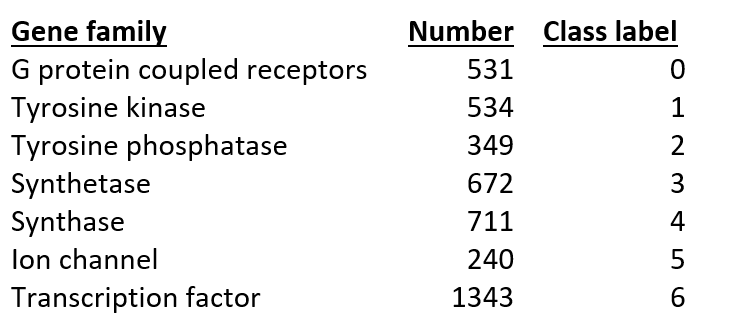

In [4]:
from IPython.display import Image
Image("D:\VIT\Capstone\Review2\gene family.png")

### We will basically apply the k-mers to the human data.

In [5]:
# function to convert sequence strings into k-mer words, default size = 6 (hexamer words)
def getKmers(sequence, size=6):
    return [sequence[x:x+size].lower() for x in range(len(sequence) - size + 1)]

In [6]:
human['words'] = human.apply(lambda x: getKmers(x['sequence']), axis=1)
human = human.drop('sequence', axis=1)

In [7]:
human.head()

,class,words
0,4,"[atgccc, tgcccc, gcccca, ccccaa, cccaac, ccaac..."
1,4,"[atgaac, tgaacg, gaacga, aacgaa, acgaaa, cgaaa..."
2,3,"[atgtgt, tgtgtg, gtgtgg, tgtggc, gtggca, tggca..."
3,3,"[atgtgt, tgtgtg, gtgtgg, tgtggc, gtggca, tggca..."
4,3,"[atgcaa, tgcaac, gcaaca, caacag, aacagc, acagc..."


### convert the lists of k-mers for each gene into string sentences of words

In [8]:
human_texts = list(human['words'])
for item in range(len(human_texts)):
    human_texts[item] = ' '.join(human_texts[item])
y_data = human.iloc[:, 0].values   

In [9]:
print(human_texts[0])

atgccc tgcccc gcccca ccccaa cccaac ccaact caacta aactaa actaaa ctaaat taaata aaatac aatact atacta tactac actacc ctaccg taccgt accgta ccgtat cgtatg gtatgg tatggc atggcc tggccc ggccca gcccac cccacc ccacca caccat accata ccataa cataat ataatt taatta aattac attacc ttaccc tacccc accccc ccccca ccccat cccata ccatac catact atactc tactcc actcct ctcctt tcctta ccttac cttaca ttacac tacact acacta cactat actatt ctattc tattcc attcct ttcctc tcctca cctcat ctcatc tcatca catcac atcacc tcaccc caccca acccaa cccaac ccaact caacta aactaa actaaa ctaaaa taaaaa aaaaat aaaata aaatat aatatt atatta tattaa attaaa ttaaac taaaca aaacac aacaca acacaa cacaaa acaaac caaact aaacta aactac actacc ctacca taccac accacc ccacct caccta acctac cctacc ctacct tacctc acctcc cctccc ctccct tccctc ccctca cctcac ctcacc tcacca caccaa accaaa ccaaag caaagc aaagcc aagccc agccca gcccat cccata ccataa cataaa ataaaa taaaaa aaaaat aaaata aaataa aataaa ataaaa taaaaa aaaaaa aaaaat aaaatt aaatta aattat attata ttataa tataac ataaca taacaa aacaaa acaaac

In [10]:
y_data

array([4, 4, 3, ..., 6, 6, 6], dtype=int64)

### Now we will apply the BAG OF WORDS using CountVectorizer using NLP

In [11]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(ngram_range=(4,4))
X = cv.fit_transform(human_texts)

In [12]:
print(X.shape)

(4380, 232414)


### If we have a look at class balance we can see we have relatively balanced dataset.

<AxesSubplot:>

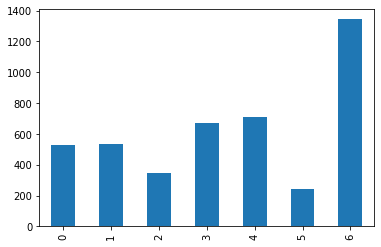

In [13]:
human['class'].value_counts().sort_index().plot.bar()

In [14]:
# Splitting the human dataset into the training set and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y_data, 
                                                    test_size = 0.20, 
                                                    random_state=42)

In [15]:
print(X_train.shape)
print(X_test.shape)

(3504, 232414)
(876, 232414)


In [16]:
from sklearn.model_selection import StratifiedKFold,cross_val_score,cross_val_predict
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

In [17]:
def get_metrics(y_test, y_predicted):
    accuracy = accuracy_score(y_test, y_predicted)
    precision = precision_score(y_test, y_predicted, average='weighted')
    recall = recall_score(y_test, y_predicted, average='weighted')
    f1 = f1_score(y_test, y_predicted, average='weighted')
    return accuracy, precision, recall, f1

In [18]:
acc = []
f1s = []
y=y_data.copy()
print("Decision Classifier :")
for i,(train_index,val_index)  in enumerate(StratifiedKFold(n_splits=5,shuffle=True,random_state=42).split(X,y)):
    dt =DecisionTreeClassifier()
    dt.fit(X[train_index],y[train_index])
    pred=dt.predict(X[val_index])
    accuracy, precision, recall, f1 = get_metrics(y[val_index], pred)
    print(str(i)+" Iteration : Accuracy = %.5f     F1_Score = %.5f" % (accuracy, f1))
    acc.append(accuracy)
    f1s.append(f1)
acc_dt = max(acc)
f1s_dt = max(f1s)

Decision Classifier :
0 Iteration : Accuracy = 0.81164     F1_Score = 0.81660
1 Iteration : Accuracy = 0.81849     F1_Score = 0.82168
2 Iteration : Accuracy = 0.80137     F1_Score = 0.80536
3 Iteration : Accuracy = 0.81735     F1_Score = 0.82270
4 Iteration : Accuracy = 0.79795     F1_Score = 0.80239


In [19]:
acc = []
f1s = []
y=y_data.copy()
print("Random Forest Classifier :")
for i,(train_index,val_index)  in enumerate(StratifiedKFold(n_splits=5,shuffle=True,random_state=42).split(X,y)):
    rf = RandomForestClassifier(n_jobs=-1)
    rf.fit(X[train_index],y[train_index])
    pred=rf.predict(X[val_index])
    accuracy, precision, recall, f1 = get_metrics(y[val_index], pred)
    print(str(i)+" Iteration : Accuracy = %.5f     F1_Score = %.5f" % (accuracy, f1))
    acc.append(accuracy)
    f1s.append(f1)
acc_rf = max(acc)
f1s_rf = max(f1s)

Random Forest Classifier :
0 Iteration : Accuracy = 0.90868     F1_Score = 0.91012
1 Iteration : Accuracy = 0.92237     F1_Score = 0.92300
2 Iteration : Accuracy = 0.89041     F1_Score = 0.89441
3 Iteration : Accuracy = 0.91667     F1_Score = 0.91718
4 Iteration : Accuracy = 0.89498     F1_Score = 0.89906


In [20]:
## Used Grid Search to find the best Hyperparameters.
acc = []
f1s = []
print("Naive Bayes Classifier :")
for i,(train_index,val_index)  in enumerate(StratifiedKFold(n_splits=5,shuffle=True,random_state=42).split(X,y)):
    classifier = MultinomialNB(alpha=0.1)
    classifier.fit(X[train_index],y[train_index])
    pred=classifier.predict(X[val_index])
    accuracy, precision, recall, f1 = get_metrics(y[val_index], pred)
    print(str(i)+" Iteration : Accuracy = %.5f    F1_Score = %.5f" % (accuracy, f1))
    acc.append(accuracy)
    f1s.append(f1)
acc_nb = max(acc)
f1s_nb = max(f1s)

Naive Bayes Classifier :
0 Iteration : Accuracy = 0.98059    F1_Score = 0.98061
1 Iteration : Accuracy = 0.98059    F1_Score = 0.98066
2 Iteration : Accuracy = 0.97603    F1_Score = 0.97606
3 Iteration : Accuracy = 0.97717    F1_Score = 0.97722
4 Iteration : Accuracy = 0.97717    F1_Score = 0.97715


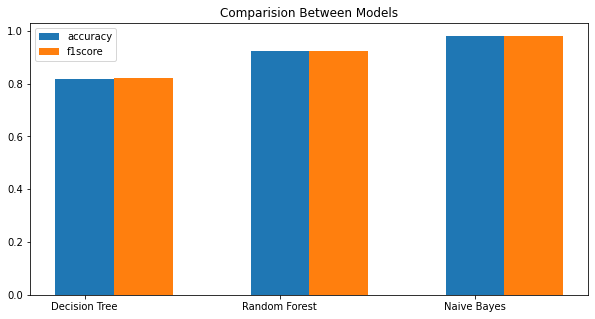

In [21]:
plt.figure(figsize=(10,5))
scores=["Decision Tree","Random Forest","Naive Bayes"]
accscore=[acc_dt,acc_rf,acc_nb]
f1score=[f1s_dt,f1s_rf,f1s_nb]
w=0.3
bar1=np.arange(len(scores))
bar2=[i+w for i in bar1]

plt.bar(bar1,accscore,w,label="accuracy")
plt.bar(bar2,f1score,w,label="f1score")
plt.xticks(bar1, scores)
plt.legend()
plt.title("Comparision Between Models")
plt.show()

In [22]:
print(bar1)
print(bar2)

[0 1 2]
[0.3, 1.3, 2.3]


In [23]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = 0.20, 
                                                    random_state=42)
nb_ =MultinomialNB(alpha=0.01)
nb_.fit(X_train, y_train)

y_pred = nb_.predict(X_test)
print(pd.crosstab(pd.Series(y_test, name='Actual'), pd.Series(y_pred, name='Predicted')))

Predicted   0    1   2    3    4   5    6
Actual                                   
0          99    0   0    0    0   0    3
1           0  100   0    0    0   0    6
2           0    0  78    0    0   0    0
3           0    0   0  122    0   0    3
4           0    0   0    0  143   0    6
5           0    0   0    0    0  51    0
6           0    0   0    0    0   0  265


In [24]:
import pickle
filename = 'finalized_model.sav'
pickle.dump(nb_, open(filename, 'wb'))

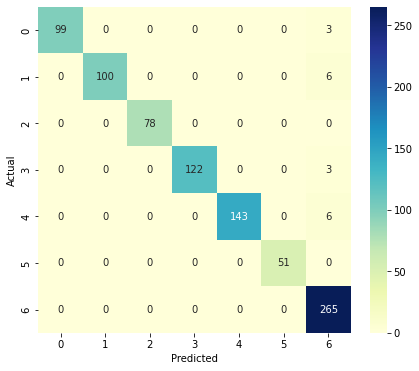

In [25]:
plt.figure(figsize=(7,6))
sns_plot = sns.heatmap(pd.crosstab(pd.Series(y_test, name='Actual'), pd.Series(y_pred, name='Predicted')),cmap="YlGnBu",annot=True,fmt='d')

In [26]:
fig = sns_plot.get_figure()
fig.savefig("cm human.png")

### Testing our Model on Chimpanzee data and Dog Data


In [27]:
chimp = pd.read_table('D:\VIT\Capstone\Review2\chimp_data.txt')
dog = pd.read_table('D:\VIT\Capstone\Review2\dog_data.txt')
chimp.head()

,sequence,class
0,ATGCCCCAACTAAATACCGCCGTATGACCCACCATAATTACCCCCA...,4
1,ATGAACGAAAATCTATTCGCTTCATTCGCTGCCCCCACAATCCTAG...,4
2,ATGGCCTCGCGCTGGTGGCGGTGGCGACGCGGCTGCTCCTGGAGGC...,4
3,ATGGCCTCGCGCTGGTGGCGGTGGCGACGCGGCTGCTCCTGGAGGC...,4
4,ATGGGCAGCGCCAGCCCGGGTCTGAGCAGCGTGTCCCCCAGCCACC...,6


In [28]:
dog.head()

,sequence,class
0,ATGCCACAGCTAGATACATCCACCTGATTTATTATAATCTTTTCAA...,4
1,ATGAACGAAAATCTATTCGCTTCTTTCGCTGCCCCCTCAATAATAG...,4
2,ATGGAAACACCCTTCTACGGCGATGAGGCGCTGAGCGGCCTGGGCG...,6
3,ATGTGCACTAAAATGGAACAGCCCTTCTACCACGACGACTCATACG...,6
4,ATGAGCCGGCAGCTAAACAGAAGCCAGAACTGCTCCTTCAGTGACG...,0


In [29]:
chimp['words'] = chimp.apply(lambda x: getKmers(x['sequence']), axis=1)
dog['words'] = dog.apply(lambda x: getKmers(x['sequence']), axis=1)

In [30]:
chimp_texts = list(chimp['words'])
for item in range(len(chimp_texts)):
    chimp_texts[item] = ' '.join(chimp_texts[item])
y_c = chimp.iloc[:, 1].values                      

dog_texts = list(dog['words'])
for item in range(len(dog_texts)):
    dog_texts[item] = ' '.join(dog_texts[item])
y_d = dog.iloc[:, 1].values        

In [31]:
X_chimp = cv.transform(chimp_texts)
X_dog = cv.transform(dog_texts)

In [32]:
print(X_chimp.shape)
print(X_dog.shape)

(1682, 232414)
(820, 232414)


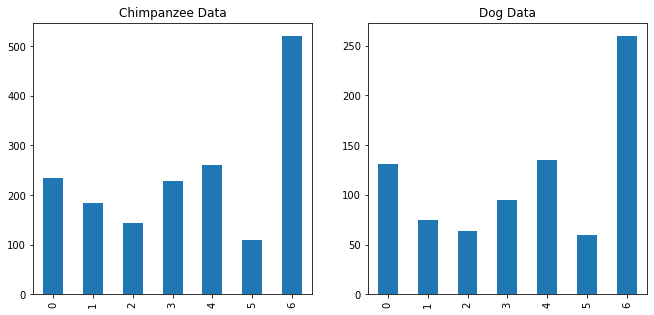

In [33]:
plt.figure(figsize=(11,5))
plt.subplot(1,2,1)
chimp['class'].value_counts().sort_index().plot.bar()
plt.title("Chimpanzee Data");
plt.subplot(1,2,2)
dog['class'].value_counts().sort_index().plot.bar()
plt.title("Dog Data");

In [34]:
# Predicting the chimp, dog and worm sequences
y_pred_chimp = nb_.predict(X_chimp)
y_pred_dog = nb_.predict(X_dog)

In [35]:
# performance on chimp genes
print("Confusion matrix\n")
print(pd.crosstab(pd.Series(y_c, name='Actual'), pd.Series(y_pred_chimp, name='Predicted')))
accuracy, precision, recall, f1 = get_metrics(y_c, y_pred_chimp)
print("accuracy = %.3f \nprecision = %.3f \nrecall = %.3f \nf1 = %.3f" % (accuracy, precision, recall, f1))

Confusion matrix

Predicted    0    1    2    3    4    5    6
Actual                                      
0          231    0    0    0    0    0    3
1            0  179    0    0    0    0    6
2            0    0  144    0    0    0    0
3            0    0    0  225    0    0    3
4            1    0    0    0  253    0    7
5            0    0    0    0    0  109    0
6            0    0    0    0    0    0  521
accuracy = 0.988 
precision = 0.989 
recall = 0.988 
f1 = 0.988


<AxesSubplot:xlabel='Predicted', ylabel='Actual'>

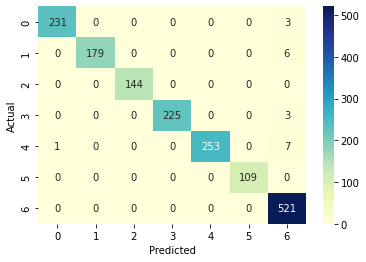

In [36]:
mat = pd.crosstab(pd.Series(y_c, name='Actual'), pd.Series(y_pred_chimp, name='Predicted'))
sns.heatmap(mat,cmap="YlGnBu",annot=True,fmt='d')

In [37]:
fig = sns_plot.get_figure()
fig.savefig("cm chimp.png")

In [38]:
# performance on dog genes
print("Confusion matrix\n")
print(pd.crosstab(pd.Series(y_d, name='Actual'), pd.Series(y_pred_dog, name='Predicted')))
accuracy, precision, recall, f1 = get_metrics(y_d, y_pred_dog)
print("accuracy = %.3f \nprecision = %.3f \nrecall = %.3f \nf1 = %.3f" % (accuracy, precision, recall, f1))

Confusion matrix

Predicted    0   1   2   3    4   5    6
Actual                                  
0          124   0   0   0    0   0    7
1            0  52   0   0    0   0   23
2            0   0  43   0    0   0   21
3            1   0   0  64    1   0   29
4            0   0   0   0  110   0   25
5            0   0   0   0    0  40   20
6            0   0   0   0    0   0  260
accuracy = 0.845 
precision = 0.894 
recall = 0.845 
f1 = 0.847


<AxesSubplot:xlabel='Predicted', ylabel='Actual'>

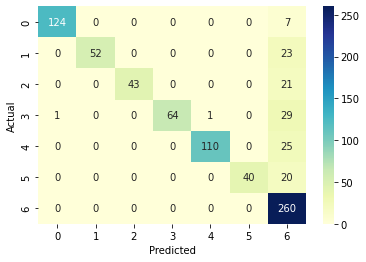

In [39]:
mat = (pd.crosstab(pd.Series(y_d, name='Actual'), pd.Series(y_pred_dog, name='Predicted')))
sns.heatmap(mat,cmap="YlGnBu",annot=True,fmt='d')

In [40]:
fig = sns_plot.get_figure()
fig.savefig("cm dog.png")

# DNA Sequence Classification using Deep Learning Techniques

#### Transform Learning on Human Data

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests

SEQUENCES_URL = 'https://raw.githubusercontent.com/pk13041991/DNA-SEQUENCING/master/deep-learning-genomics-primer-master/deep-learning-genomics-primer-master/sequences.txt?token=GHSAT0AAAAAABRLL2JL5HIZVXVGPFJQTGJIYSCF56A'

sequences = requests.get(SEQUENCES_URL).text.split('\n')
sequences = list(filter(None, sequences))  # This removes empty sequences.

# Let's print the first few sequences.
pd.DataFrame(sequences, index=np.arange(1, len(sequences)+1), 
             columns=['Sequences']).head()

from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# The LabelEncoder encodes a sequence of bases as a sequence of integers.
integer_encoder = LabelEncoder()  
# The OneHotEncoder converts an array of integers to a sparse matrix where 
# each row corresponds to one possible value of each feature.
one_hot_encoder = OneHotEncoder(categories='auto')   
input_features = []

for sequence in sequences:
  integer_encoded = integer_encoder.fit_transform(list(sequence))
  integer_encoded = np.array(integer_encoded).reshape(-1, 1)
  one_hot_encoded = one_hot_encoder.fit_transform(integer_encoded)
  input_features.append(one_hot_encoded.toarray())

np.set_printoptions(threshold=40)
input_features = np.stack(input_features)
print("Example sequence\n-----------------------")
print('DNA Sequence #1:\n',sequences[0][:10],'...',sequences[0][-10:])
print('One hot encoding of Sequence #1:\n',input_features[0].T)


LABELS_URL = 'https://raw.githubusercontent.com/pk13041991/DNA-SEQUENCING/master/hlabel.txt?token=GHSAT0AAAAAABRLL2JLU2M3YKXQPAMZ6DJIYSCGAVQ'

labels = requests.get(LABELS_URL).text.split('\n')
labels = list(filter(None, labels))  # removes empty sequences

one_hot_encoder = OneHotEncoder(categories='auto')
labels = np.array(labels).reshape(-1, 1)
input_labels = one_hot_encoder.fit_transform(labels).toarray()

print('Labels:\n',labels.T)
print('One-hot encoded labels:\n',input_labels.T)

from sklearn.model_selection import train_test_split

train_features, test_features, train_labels, test_labels = train_test_split(
    input_features, input_labels, test_size=0.25, random_state=42)


from tensorflow.keras.layers import Conv1D, Dense, MaxPooling1D, Flatten
from tensorflow.keras.models import Sequential

model = Sequential()
model.add(Conv1D(filters=32, kernel_size=12, 
                 input_shape=(train_features.shape[1], 4)))
model.add(MaxPooling1D(pool_size=4))
model.add(Flatten())
model.add(Dense(16, activation='relu'))
model.add(Dense(7, activation='softmax'))

model.compile(loss='binary_crossentropy', optimizer='adam', 
              metrics=['binary_accuracy'])
model.summary()
  

Example sequence
-----------------------
DNA Sequence #1:
 CCGAGGGCTA ... CGCGGACACC
One hot encoding of Sequence #1:
 [[0. 0. 0. ... 1. 0. 0.]
 [1. 1. 0. ... 0. 1. 1.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Labels:
 [['4' '4' '3' ... '6' '0' '1']]
One-hot encoded labels:
 [[0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [1. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]]
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 39, 32)            1568      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 9, 32)            0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 288)               0         
          

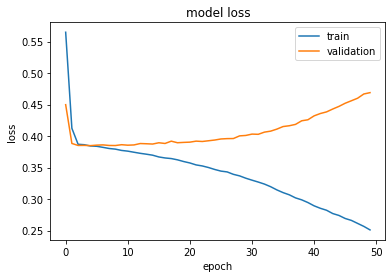

In [42]:
history = model.fit(train_features, train_labels, 
                    epochs=50, verbose=0, validation_split=0.25)

plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

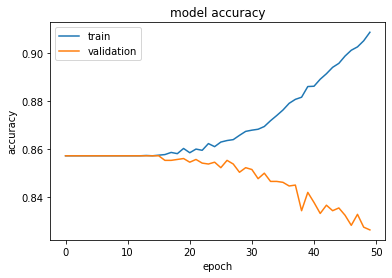

In [43]:
plt.figure()
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

Confusion matrix:
 [[ 6  7  0 ...  4  0 30]
 [ 4  5  1 ... 15  0 40]
 [ 5  3  1 ...  4  0 14]
 ...
 [ 4  6  0 ...  7  0 35]
 [ 1  2  0 ...  3  0 11]
 [11 27  1 ... 20  0 80]]


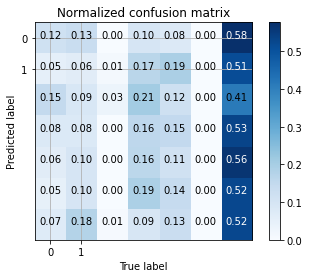

In [44]:
from sklearn.metrics import confusion_matrix
import itertools

predicted_labels = model.predict(np.stack(test_features))
cm = confusion_matrix(np.argmax(test_labels, axis=1), 
                      np.argmax(predicted_labels, axis=1))
print('Confusion matrix:\n',cm)

cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]

plt.imshow(cm, cmap=plt.cm.Blues)
plt.title('Normalized confusion matrix')
plt.colorbar()
plt.xlabel('True label')
plt.ylabel('Predicted label')
plt.xticks([0, 1]); plt.yticks([0, 1])
plt.grid('off')
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], '.2f'),
             horizontalalignment='center',
             color='white' if cm[i, j] > 0.5 else 'black')
plt.savefig('tlh cm.png')

#### Transform Learning on Chimp Data

Example sequence
-----------------------
DNA Sequence #1:
 CTTCCCAGAA ... GTAAGCGTTT
One hot encoding of Sequence #1:
 [[0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 1. ... 1. 1. 1.]]
Labels:
 [['4\r' '1\r' '1\r' ... '3\r' '3\r' '4']]
One-hot encoded labels:
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 1. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Confusion matrix:
 [[ 20   5   1 ...   0  24   0]
 [  7  61   1 ...   0  62   0]
 [  4   4   3 ...   0  15   0]
 ...
 [  5   4   2 ...   0  30   0]
 [  1   1   1 ...   3  11   0]
 [  3  14   1 ...   0 101   0]]


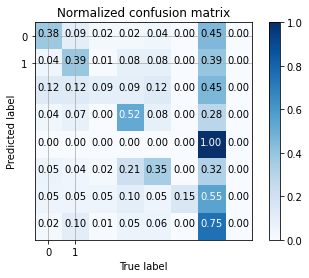

In [45]:

    
SEQUENCES_URL = 'https://raw.githubusercontent.com/pk13041991/DNA-SEQUENCING/master/chimpsequences.txt'

sequences = requests.get(SEQUENCES_URL).text.split('\n')
sequences = list(filter(None, sequences))  # This removes empty sequences.

# Let's print the first few sequences.
pd.DataFrame(sequences, index=np.arange(1, len(sequences)+1), 
             columns=['Sequences']).head()

from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# The LabelEncoder encodes a sequence of bases as a sequence of integers.
integer_encoder = LabelEncoder()  
# The OneHotEncoder converts an array of integers to a sparse matrix where 
# each row corresponds to one possible value of each feature.
one_hot_encoder = OneHotEncoder(categories='auto')   
input_features = []

for sequence in sequences:
  integer_encoded = integer_encoder.fit_transform(list(sequence))
  integer_encoded = np.array(integer_encoded).reshape(-1, 1)
  one_hot_encoded = one_hot_encoder.fit_transform(integer_encoded)
  input_features.append(one_hot_encoded.toarray())

np.set_printoptions(threshold=40)
input_features = np.stack(input_features)
print("Example sequence\n-----------------------")
print('DNA Sequence #1:\n',sequences[0][:10],'...',sequences[0][-10:])
print('One hot encoding of Sequence #1:\n',input_features[0].T)


LABELS_URL = 'https://raw.githubusercontent.com/pk13041991/DNA-SEQUENCING/master/chimplabel.txt'

labels = requests.get(LABELS_URL).text.split('\n')
labels = list(filter(None, labels))  # removes empty sequences

one_hot_encoder = OneHotEncoder(categories='auto')
labels = np.array(labels).reshape(-1, 1)
input_labels = one_hot_encoder.fit_transform(labels).toarray()

print('Labels:\n',labels.T)
print('One-hot encoded labels:\n',input_labels.T)


predicted_labels = model.predict(np.stack(input_features))

cm = confusion_matrix(np.argmax(input_labels, axis=1), 
                      np.argmax(predicted_labels, axis=1))
print('Confusion matrix:\n',cm)

cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]

plt.imshow(cm, cmap=plt.cm.Blues)
plt.title('Normalized confusion matrix')
plt.colorbar()
plt.xlabel('True label')
plt.ylabel('Predicted label')
plt.xticks([0, 1]); plt.yticks([0, 1])
plt.grid('off')
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], '.2f'),
             horizontalalignment='center',
             color='white' if cm[i, j] > 0.5 else 'black')
plt.savefig('tlc cm.png')

#### Transform Learning on Dog Data

Example sequence
-----------------------
DNA Sequence #1:
 TTGCGGGGGC ... TGTTCACGTC
One hot encoding of Sequence #1:
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 1. ... 1. 0. 0.]
 [1. 1. 0. ... 0. 1. 0.]]
Labels:
 [['1\r' '1\r' '4\r' ... '6\r' '6\r' '6']]
One-hot encoded labels:
 [[0. 0. 0. ... 0. 0. 0.]
 [1. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 1. 1. 0.]]
Confusion matrix:
 [[ 8  5  0 ...  0  9  0]
 [ 1 15  0 ...  0 31  0]
 [ 2  1  0 ...  0  7  0]
 ...
 [ 1  1  0 ...  1 20  0]
 [ 0  0  0 ...  0  1  0]
 [ 2 15  2 ...  0 42  0]]


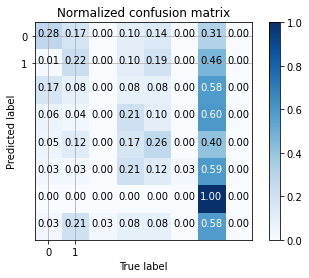

In [46]:
SEQUENCES_URL = 'https://raw.githubusercontent.com/pk13041991/DNA-SEQUENCING/master/dogsequences.txt'

sequences = requests.get(SEQUENCES_URL).text.split('\n')
sequences = list(filter(None, sequences))  # This removes empty sequences.

# Let's print the first few sequences.
pd.DataFrame(sequences, index=np.arange(1, len(sequences)+1), 
             columns=['Sequences']).head()

from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# The LabelEncoder encodes a sequence of bases as a sequence of integers.
integer_encoder = LabelEncoder()  
# The OneHotEncoder converts an array of integers to a sparse matrix where 
# each row corresponds to one possible value of each feature.
one_hot_encoder = OneHotEncoder(categories='auto')   
input_features = []

for sequence in sequences:
  integer_encoded = integer_encoder.fit_transform(list(sequence))
  integer_encoded = np.array(integer_encoded).reshape(-1, 1)
  one_hot_encoded = one_hot_encoder.fit_transform(integer_encoded)
  input_features.append(one_hot_encoded.toarray())

np.set_printoptions(threshold=40)
input_features = np.stack(input_features)
print("Example sequence\n-----------------------")
print('DNA Sequence #1:\n',sequences[0][:10],'...',sequences[0][-10:])
print('One hot encoding of Sequence #1:\n',input_features[0].T)


LABELS_URL = 'https://raw.githubusercontent.com/pk13041991/DNA-SEQUENCING/master/doglabel.txt'

labels = requests.get(LABELS_URL).text.split('\n')
labels = list(filter(None, labels))  # removes empty sequences

one_hot_encoder = OneHotEncoder(categories='auto')
labels = np.array(labels).reshape(-1, 1)
input_labels = one_hot_encoder.fit_transform(labels).toarray()

print('Labels:\n',labels.T)
print('One-hot encoded labels:\n',input_labels.T)


predicted_labels = model.predict(np.stack(input_features))

cm = confusion_matrix(np.argmax(input_labels, axis=1), 
                      np.argmax(predicted_labels, axis=1))
print('Confusion matrix:\n',cm)

cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]

plt.imshow(cm, cmap=plt.cm.Blues)
plt.title('Normalized confusion matrix')
plt.colorbar()
plt.xlabel('True label')
plt.ylabel('Predicted label')
plt.xticks([0, 1]); plt.yticks([0, 1])
plt.grid('off')
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], '.2f'),
             horizontalalignment='center',
             color='white' if cm[i, j] > 0.5 else 'black')
plt.savefig('tld cm.png')

#### CNN on Human Data

In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests

SEQUENCES_URL = 'https://raw.githubusercontent.com/pk13041991/DNA-SEQUENCING/master/deep-learning-genomics-primer-master/deep-learning-genomics-primer-master/sequences.txt?token=GHSAT0AAAAAABRLL2JL5HIZVXVGPFJQTGJIYSCF56A'

sequences = requests.get(SEQUENCES_URL).text.split('\n')
sequences = list(filter(None, sequences))  # This removes empty sequences.

# Let's print the first few sequences.
pd.DataFrame(sequences, index=np.arange(1, len(sequences)+1), 
             columns=['Sequences']).head()

from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# The LabelEncoder encodes a sequence of bases as a sequence of integers.
integer_encoder = LabelEncoder()  
# The OneHotEncoder converts an array of integers to a sparse matrix where 
# each row corresponds to one possible value of each feature.
one_hot_encoder = OneHotEncoder(categories='auto')   
input_features = []

for sequence in sequences:
  integer_encoded = integer_encoder.fit_transform(list(sequence))
  integer_encoded = np.array(integer_encoded).reshape(-1, 1)
  one_hot_encoded = one_hot_encoder.fit_transform(integer_encoded)
  input_features.append(one_hot_encoded.toarray())

np.set_printoptions(threshold=40)
input_features = np.stack(input_features)
print("Example sequence\n-----------------------")
print('DNA Sequence #1:\n',sequences[0][:10],'...',sequences[0][-10:])
print('One hot encoding of Sequence #1:\n',input_features[0].T)


LABELS_URL = 'https://raw.githubusercontent.com/pk13041991/DNA-SEQUENCING/master/hlabel.txt?token=GHSAT0AAAAAABRLL2JLU2M3YKXQPAMZ6DJIYSCGAVQ'

labels = requests.get(LABELS_URL).text.split('\n')
labels = list(filter(None, labels))  # removes empty sequences

one_hot_encoder = OneHotEncoder(categories='auto')
labels = np.array(labels).reshape(-1, 1)
input_labels = one_hot_encoder.fit_transform(labels).toarray()

print('Labels:\n',labels.T)
print('One-hot encoded labels:\n',input_labels.T)

from sklearn.model_selection import train_test_split

train_features, test_features, train_labels, test_labels = train_test_split(
    input_features, input_labels, test_size=0.25, random_state=42)


from tensorflow.keras.layers import Conv1D, Dense, MaxPooling1D, Flatten
from tensorflow.keras.models import Sequential



model = Sequential()
model.add(Conv1D(filters=32, kernel_size=12, 
                 input_shape=(train_features.shape[1], 4)))
model.add(MaxPooling1D(pool_size=4))
model.add(Dense(32, activation='relu'))
model.add(MaxPooling1D(pool_size=4))
model.add(Flatten())
model.add(Dense(16, activation='relu'))
model.add(Dense(7, activation='softmax'))

model.compile(loss='binary_crossentropy', optimizer='adam', 
              metrics=['binary_accuracy'])
model.summary()
  

Example sequence
-----------------------
DNA Sequence #1:
 CCGAGGGCTA ... CGCGGACACC
One hot encoding of Sequence #1:
 [[0. 0. 0. ... 1. 0. 0.]
 [1. 1. 0. ... 0. 1. 1.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Labels:
 [['4' '4' '3' ... '6' '0' '1']]
One-hot encoded labels:
 [[0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [1. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]]
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 39, 32)            1568      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 9, 32)            0         
 1D)                                                             
                                                                 
 dense_2 (Dense)             (None, 9, 32)             1056      
        

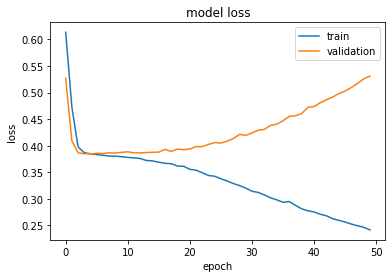

In [48]:
history = model.fit(train_features, train_labels, 
                    epochs=50, verbose=0, validation_split=0.25)

plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

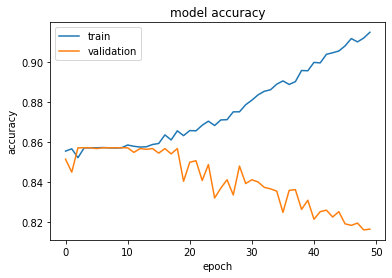

In [49]:
plt.figure()
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

Confusion matrix:
 [[ 0 12  0 ...  4  0 25]
 [ 6 16  0 ...  9  0 23]
 [ 2  5  0 ...  5  0 14]
 ...
 [ 3  9  1 ...  9  0 24]
 [ 0  4  0 ...  4  0 10]
 [ 7 30  3 ... 25  0 58]]


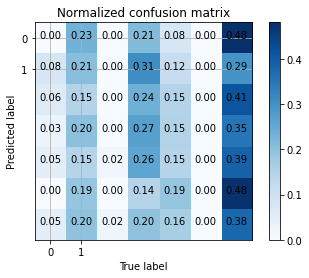

In [50]:
from sklearn.metrics import confusion_matrix
import itertools

predicted_labels = model.predict(np.stack(test_features))
cm = confusion_matrix(np.argmax(test_labels, axis=1), 
                      np.argmax(predicted_labels, axis=1))
print('Confusion matrix:\n',cm)

cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]

plt.imshow(cm, cmap=plt.cm.Blues)
plt.title('Normalized confusion matrix')
plt.colorbar()
plt.xlabel('True label')
plt.ylabel('Predicted label')
plt.xticks([0, 1]); plt.yticks([0, 1])
plt.grid('off')
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], '.2f'),
             horizontalalignment='center',
             color='white' if cm[i, j] > 0.5 else 'black')
plt.savefig('cnh cm.png')

#### CNN on Chimp Data

Example sequence
-----------------------
DNA Sequence #1:
 CTTCCCAGAA ... GTAAGCGTTT
One hot encoding of Sequence #1:
 [[0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 1. ... 1. 1. 1.]]
Labels:
 [['4\r' '1\r' '1\r' ... '3\r' '3\r' '4']]
One-hot encoded labels:
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 1. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Confusion matrix:
 [[12  8  0 ...  0 13  0]
 [ 7 86  0 ...  0 21  0]
 [ 3  5  1 ...  0  7  0]
 ...
 [ 3 22  1 ...  0 21  0]
 [ 0  4  1 ...  0  3  0]
 [ 4  9  3 ...  0 95  0]]


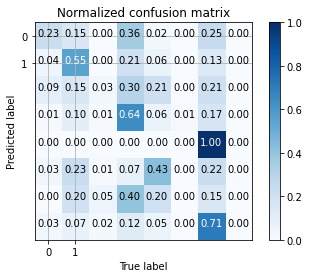

In [51]:

    
SEQUENCES_URL = 'https://raw.githubusercontent.com/pk13041991/DNA-SEQUENCING/master/chimpsequences.txt'

sequences = requests.get(SEQUENCES_URL).text.split('\n')
sequences = list(filter(None, sequences))  # This removes empty sequences.

# Let's print the first few sequences.
pd.DataFrame(sequences, index=np.arange(1, len(sequences)+1), 
             columns=['Sequences']).head()

from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# The LabelEncoder encodes a sequence of bases as a sequence of integers.
integer_encoder = LabelEncoder()  
# The OneHotEncoder converts an array of integers to a sparse matrix where 
# each row corresponds to one possible value of each feature.
one_hot_encoder = OneHotEncoder(categories='auto')   
input_features = []

for sequence in sequences:
  integer_encoded = integer_encoder.fit_transform(list(sequence))
  integer_encoded = np.array(integer_encoded).reshape(-1, 1)
  one_hot_encoded = one_hot_encoder.fit_transform(integer_encoded)
  input_features.append(one_hot_encoded.toarray())

np.set_printoptions(threshold=40)
input_features = np.stack(input_features)
print("Example sequence\n-----------------------")
print('DNA Sequence #1:\n',sequences[0][:10],'...',sequences[0][-10:])
print('One hot encoding of Sequence #1:\n',input_features[0].T)


LABELS_URL = 'https://raw.githubusercontent.com/pk13041991/DNA-SEQUENCING/master/chimplabel.txt'

labels = requests.get(LABELS_URL).text.split('\n')
labels = list(filter(None, labels))  # removes empty sequences

one_hot_encoder = OneHotEncoder(categories='auto')
labels = np.array(labels).reshape(-1, 1)
input_labels = one_hot_encoder.fit_transform(labels).toarray()

print('Labels:\n',labels.T)
print('One-hot encoded labels:\n',input_labels.T)


predicted_labels = model.predict(np.stack(input_features))

cm = confusion_matrix(np.argmax(input_labels, axis=1), 
                      np.argmax(predicted_labels, axis=1))
print('Confusion matrix:\n',cm)

cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]

plt.imshow(cm, cmap=plt.cm.Blues)
plt.title('Normalized confusion matrix')
plt.colorbar()
plt.xlabel('True label')
plt.ylabel('Predicted label')
plt.xticks([0, 1]); plt.yticks([0, 1])
plt.grid('off')
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], '.2f'),
             horizontalalignment='center',
             color='white' if cm[i, j] > 0.5 else 'black')
plt.savefig('cnc cm.png')

#### CNN on Dog Data

Example sequence
-----------------------
DNA Sequence #1:
 TTGCGGGGGC ... TGTTCACGTC
One hot encoding of Sequence #1:
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 1. ... 1. 0. 0.]
 [1. 1. 0. ... 0. 1. 0.]]
Labels:
 [['1\r' '1\r' '4\r' ... '6\r' '6\r' '6']]
One-hot encoded labels:
 [[0. 0. 0. ... 0. 0. 0.]
 [1. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 1. 1. 0.]]
Confusion matrix:
 [[ 5  5  0 ...  0  5  0]
 [ 1 26  1 ...  0 17  0]
 [ 0  0  0 ...  0  6  0]
 ...
 [ 0  6  0 ...  0  7  0]
 [ 0  1  0 ...  0  0  0]
 [ 5 16  0 ...  0 31  0]]


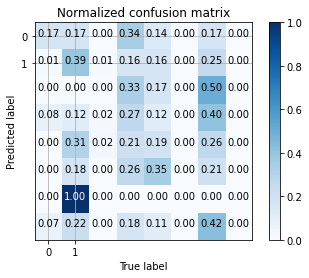

In [52]:
SEQUENCES_URL = 'https://raw.githubusercontent.com/pk13041991/DNA-SEQUENCING/master/dogsequences.txt'

sequences = requests.get(SEQUENCES_URL).text.split('\n')
sequences = list(filter(None, sequences))  # This removes empty sequences.

# Let's print the first few sequences.
pd.DataFrame(sequences, index=np.arange(1, len(sequences)+1), 
             columns=['Sequences']).head()

from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# The LabelEncoder encodes a sequence of bases as a sequence of integers.
integer_encoder = LabelEncoder()  
# The OneHotEncoder converts an array of integers to a sparse matrix where 
# each row corresponds to one possible value of each feature.
one_hot_encoder = OneHotEncoder(categories='auto')   
input_features = []

for sequence in sequences:
  integer_encoded = integer_encoder.fit_transform(list(sequence))
  integer_encoded = np.array(integer_encoded).reshape(-1, 1)
  one_hot_encoded = one_hot_encoder.fit_transform(integer_encoded)
  input_features.append(one_hot_encoded.toarray())

np.set_printoptions(threshold=40)
input_features = np.stack(input_features)
print("Example sequence\n-----------------------")
print('DNA Sequence #1:\n',sequences[0][:10],'...',sequences[0][-10:])
print('One hot encoding of Sequence #1:\n',input_features[0].T)


LABELS_URL = 'https://raw.githubusercontent.com/pk13041991/DNA-SEQUENCING/master/doglabel.txt'

labels = requests.get(LABELS_URL).text.split('\n')
labels = list(filter(None, labels))  # removes empty sequences

one_hot_encoder = OneHotEncoder(categories='auto')
labels = np.array(labels).reshape(-1, 1)
input_labels = one_hot_encoder.fit_transform(labels).toarray()

print('Labels:\n',labels.T)
print('One-hot encoded labels:\n',input_labels.T)


predicted_labels = model.predict(np.stack(input_features))

cm = confusion_matrix(np.argmax(input_labels, axis=1), 
                      np.argmax(predicted_labels, axis=1))
print('Confusion matrix:\n',cm)

cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]

plt.imshow(cm, cmap=plt.cm.Blues)
plt.title('Normalized confusion matrix')
plt.colorbar()
plt.xlabel('True label')
plt.ylabel('Predicted label')
plt.xticks([0, 1]); plt.yticks([0, 1])
plt.grid('off')
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], '.2f'),
             horizontalalignment='center',
             color='white' if cm[i, j] > 0.5 else 'black')
plt.savefig('cnd cm.png')

### Comparision of All Algorithms

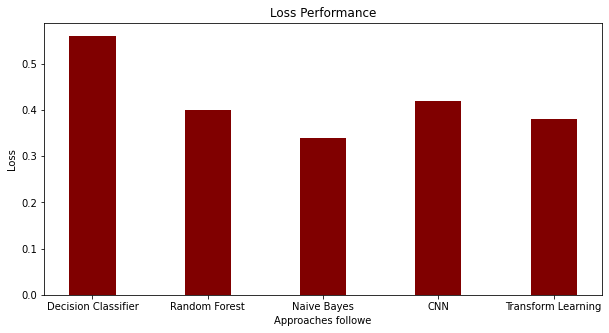

In [53]:
import numpy as np
import matplotlib.pyplot as plt
 
  
# creating the dataset
data = {'Decision Classifier':0.56, 'Random Forest':0.40, 'Naive Bayes':0.34, 
'CNN':0.42, 'Transform Learning':0.38}
courses = list(data.keys())
values = list(data.values())
  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(courses, values, color ='maroon',
        width = 0.4)
 
plt.xlabel("Approaches followe")
plt.ylabel("Loss")
plt.title("Loss Performance")
plt.show()

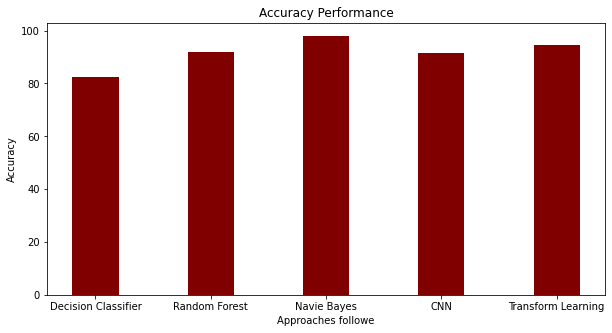

In [54]:
import numpy as np
import matplotlib.pyplot as plt
 
  
# creating the dataset
data = {'Decision Classifier':82.6, 'Random Forest':91.8, 'Navie Bayes':98.0, 'CNN':91.45,
        'Transform Learning':94.57}
courses = list(data.keys())
values = list(data.values())
  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot0
plt.bar(courses, values, color ='maroon',
        width = 0.4)
 
plt.xlabel("Approaches followe")
plt.ylabel("Accuracy")
plt.title("Accuracy Performance")
plt.show()